In [114]:
!pip install --upgrade tensorflow

  Using cached pygments-2.19.2-py3-none-any.whl.metadata (2.5 kB)
Using cached pygments-2.19.2-py3-none-any.whl (1.2 MB)


In [115]:
from tensorflow.keras.applications import VGG16

In [116]:
import os, zipfile, random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
import os, zipfile, random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.manifold import TSNE

In [220]:
zip_path    = '/Users/arshzair/Downloads/used_smartphone_images.zip'
extract_dir = 'used_smartphone_images'
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zp:
        zp.extractall(extract_dir)
        print("Extracted to", extract_dir)

import cv2
def preprocess_edge(img):
    gray  = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)
    # Bring back to 3-channel float [0–1]
    return cv2.merge([edges, edges, edges]).astype('float32') / 255.0

def load_images_from_folder(folder):
    imgs, fnames = [], []
    for fn in sorted(os.listdir(folder)):
        path = os.path.join(folder, fn)
        img  = cv2.imread(path)
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150,150)) 
        imgs.append(img)
        fnames.append(fn)
    return np.array(imgs), fnames

images, filenames = load_images_from_folder(extract_dir)
print("Loaded images:", images.shape)

Loaded images: (820, 150, 150, 3)


In [224]:
def extract_features(images):
    model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(150,150,3),
        pooling='avg'
    )
    model.trainable = False
    x = preprocess_input(images.astype('float32'))
    feats = model.predict(x)
    return feats 

features = extract_features(images)
print("VGG16 features shape:", features.shape)


26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step
VGG16 features shape: (820, 512)


In [204]:
#Flatten Features
def flatten_features(feats):
    return feats.reshape(feats.shape[0], -1)

flat_feats = flatten_features(features)  # should be (N, 512)
print("Flattened shape:", flat_feats.shape)

# Principal Component Analysis 
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(flat_feats)
print("PCA reduced shape:", X_pca.shape,
      "| Variance retained:", pca.explained_variance_ratio_.sum().round(3))

Flattened shape: (820, 512)
PCA reduced shape: (820, 50) | Variance retained: 0.943


k= 2 → DB index = 1.548
k= 3 → DB index = 1.518
k= 4 → DB index = 1.636
k= 5 → DB index = 1.763
k= 6 → DB index = 1.653


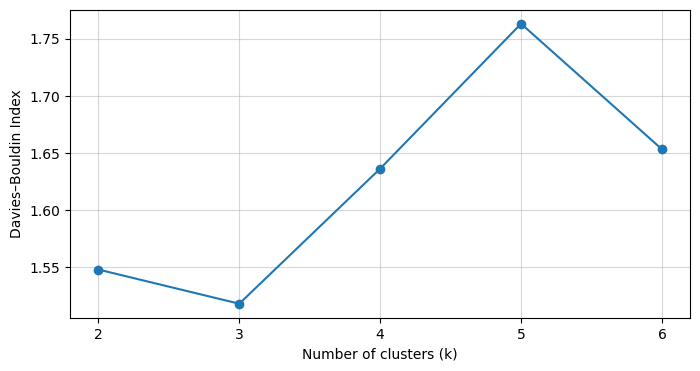

In [206]:
# Function to compute and plot Davies–Bouldin scores for a range of k
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

def davies_bouldin_method(features, max_clusters=6):
    db_scores = {}
    ks = range(2, max_clusters + 1)
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_k = kmeans.fit_predict(features)
        db = davies_bouldin_score(features, labels_k)
        db_scores[k] = db
        print(f"k={k:2d} → DB index = {db:.3f}")
    
    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(list(db_scores.keys()), list(db_scores.values()), marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Davies–Bouldin Index")
    plt.xticks(ks)
    plt.grid(alpha=0.5)
    plt.show()
    
    return db_scores

db_scores = davies_bouldin_method(X_pca)

k= 2 → DB index = 1.548
k= 3 → DB index = 1.518
k= 4 → DB index = 1.636
k= 5 → DB index = 1.763
k= 6 → DB index = 1.653


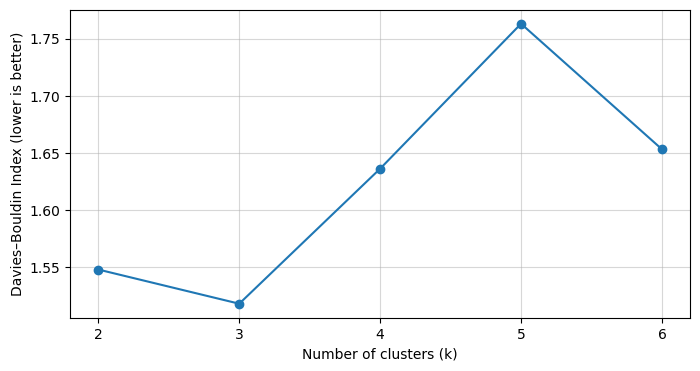

{2: 1.5481082370121797,
 3: 1.5182201617367224,
 4: 1.6363276979488834,
 5: 1.7630906594489222,
 6: 1.6532808472542933}

In [148]:
davies_bouldin_method(X_pca)

In [234]:
# Cell 6: K-Means Clustering & Metrics

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)
print("Cluster sizes:", np.bincount(labels))

Cluster sizes: [210 610]


In [244]:
# Validity Scores
sil = silhouette_score(X_pca, labels)
ch  = calinski_harabasz_score(X_pca, labels)
db  = davies_bouldin_score(X_pca, labels)


print(f"Silhouette Score:        {sil:.3f}")
print(f"Calinski–Harabasz Index: {ch:.1f}")
print(f"Davies–Bouldin Index:    {db:.3f}")

Silhouette Score:        0.306
Calinski–Harabasz Index: 264.1
Davies–Bouldin Index:    1.548


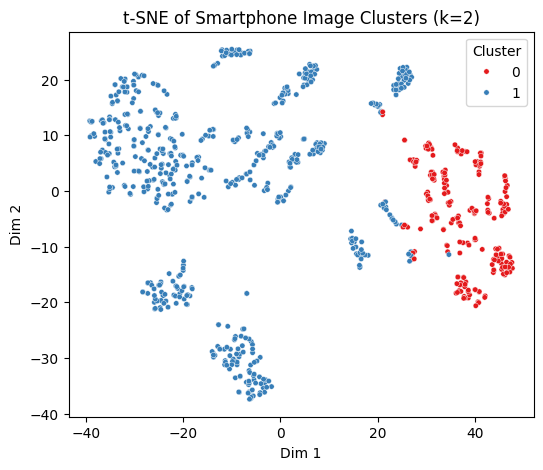

In [212]:
# 2D embedding for visualization
tsne = TSNE(n_components=2, 
            perplexity=30, 
            random_state=42, 
            init='pca', 
            learning_rate='auto'
           )
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=labels, palette='Set1', s=15
)
plt.title("t-SNE of Smartphone Image Clusters (k=2)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(title="Cluster")
plt.show()

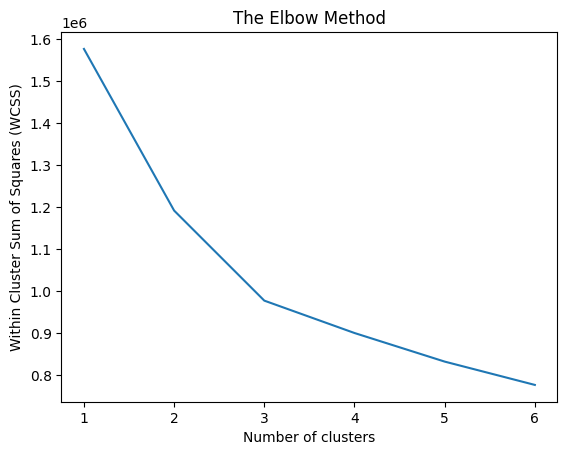

In [242]:
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', 
                random_state = 42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 7), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.show()


Sample images from each cluster:


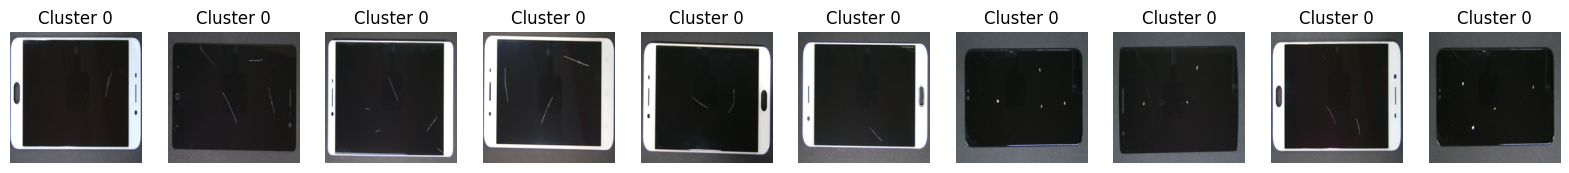

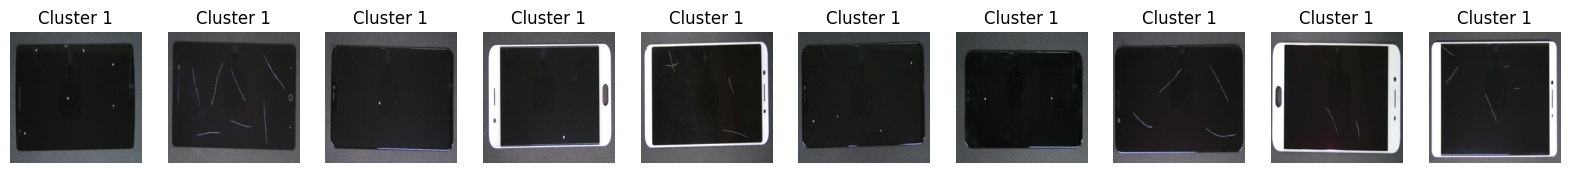

In [214]:
import random
from PIL import Image

def show_samples(cluster_id, num=10):
    idxs = np.where(labels == cluster_id)[0]
    choices = random.sample(list(idxs), min(num, len(idxs)))
    plt.figure(figsize=(num*2,2))
    for i, idx in enumerate(choices):
        img = Image.open(image_files[idx])
        img = img.resize((200,200))
        plt.subplot(1,num,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Cluster {cluster_id}")
    plt.show()

print("\nSample images from each cluster:")
show_samples(0)
show_samples(1) 

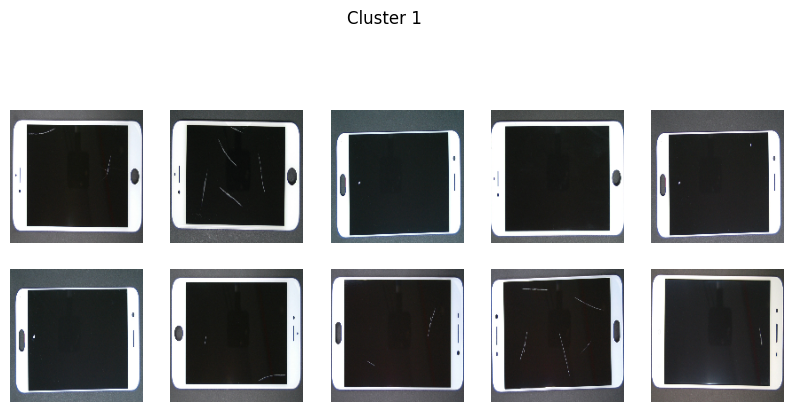

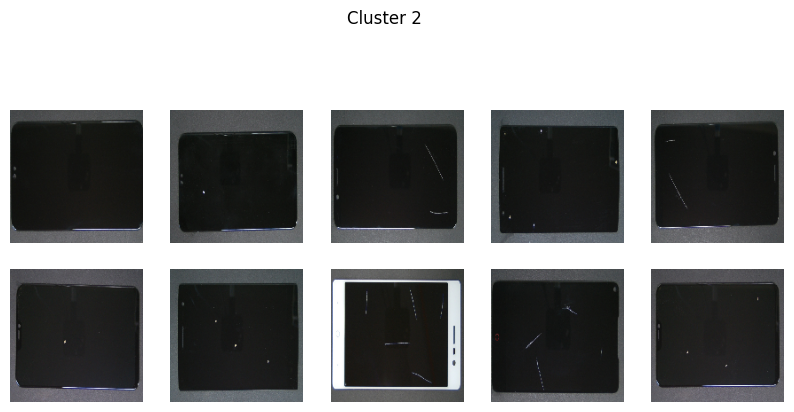

In [240]:
n_clusters = 2

for cluster in range(n_clusters):
    cluster_images = images[labels == cluster]
    plt.figure(figsize=(10, 10))
    for i in range(min(len(cluster_images), 10)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(cluster_images[i])
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster + 1}')
    plt.show()